In [132]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV,Ridge
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [2]:
df = pd.read_csv('train.tsv', sep='\t')
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


### Data Info

Below are the standard statistics (count,mean,std,min,max,etc.) and more information about the data. 

In [3]:
df.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [5]:
df.isnull().sum() #Find out nan values

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

There are null values in the category_name and brand_name columns. The null in the category_name will be replaced by 'Other' and the null in the brand_name will be replaced by 'Not Specified'.

### Item Categories

The item categories are 3 layers deep. For example: Men/Tops/T-shirt.

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


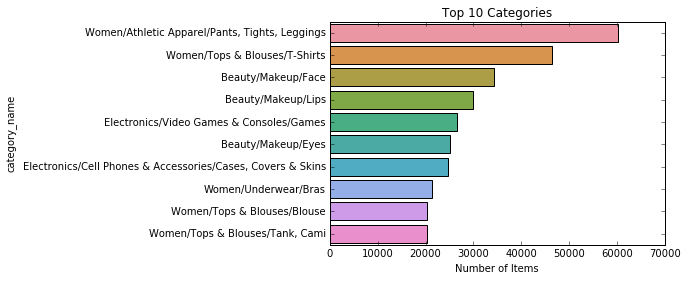

In [6]:
#Top 10 Categories
df.category_name.fillna('Other/Other/Other',inplace=True)
sns.countplot(y = df.category_name, order = df.category_name.value_counts().iloc[:10].index)
plt.title('Top 10 Categories')
plt.xlabel('Number of Items')

The most popular category is Women/Athletic Apparel/Pants, Tights, Leggings. It looks like there are a lot more items for women than men. Among the top 10 categories, 8 of them are in 'Women' category and the other 2 are 'Electronics'. 

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


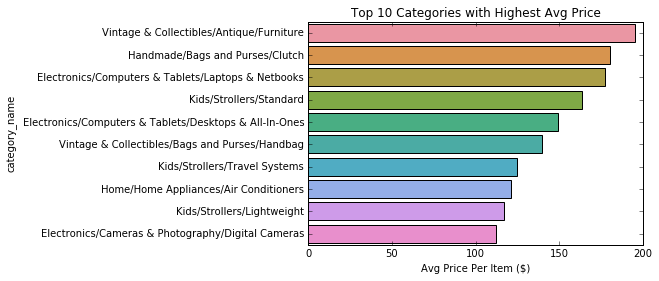

In [7]:
#Top 10 Most Expensive Categories
high_avg_price = pd.DataFrame(df.groupby('category_name')['price'].mean()).sort_values('price',ascending=0).head(10)
sns.barplot(x='price',y=high_avg_price.index,data=high_avg_price)
plt.title('Top 10 Categories with Highest Avg Price')
plt.xlabel('Avg Price Per Item ($)')

Top 10 most expensive categories are as expected with furniture, electronics, handbag, and strollers dominating. The most expensive category is Vintage & Collectibles/Antique/Furniture which items in that category have an average price of almost $200.

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


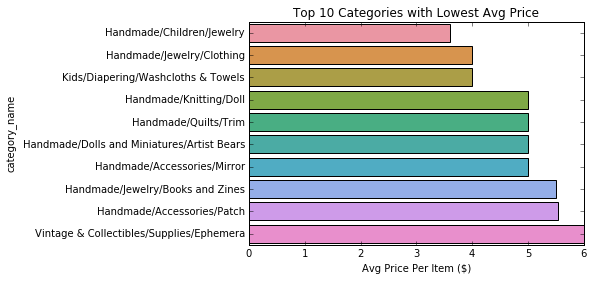

In [8]:
#Top 10 Least Expensive Categories
low_avg_price = pd.DataFrame(df.groupby('category_name')['price'].mean()).sort_values('price',ascending=1).head(10)
sns.barplot(x='price',y=low_avg_price.index,data=low_avg_price)
plt.title('Top 10 Categories with Lowest Avg Price')
plt.xlabel('Avg Price Per Item ($)')

The Top 10 least expensive categories are mostly handmade items (including jewelery which is somewhat counter intuitive).

The code below splits the 3 layers categories to each own layer. We will have category 1, category 1 2, category 2, and category 3. For the example Men/Tops/T-shirt: Men will be the 1st category, Tops the 2nd category, Men/Tops the 1_2 category, and T-shirt the 3rd category.

In [9]:
def split_cat(text): #Split category
    try: return text.split('/')
    except: return (np.nan, np.nan, np.nan)
df['category_1'], df['category_2'], df['category_3'] = zip(*df['category_name'].apply(lambda x: split_cat(x)))
df['category_1_2'] = df['category_1']+'/'+df['category_2']
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_1,category_2,category_3,category_1_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,Men/Tops
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,Electronics/Computers & Tablets
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,Women/Tops & Blouses
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,Home/Home Décor
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,Women/Jewelry


In [10]:
#How many unique categories are there?
print('category 1 unique values:',len(df.category_1.unique()))
print('category 2 unique values:',len(df.category_2.unique()))
print('category 3 unique values:',len(df.category_3.unique()))

category 1 unique values: 10
category 2 unique values: 113
category 3 unique values: 870


The plots below further explore these main and sub categories and are consistent with our previous observation. Women category has the most number of items. The most expensive categories are: Electronics, Men, and Women (because of luxury items as can be seen from the brands analysis in the next section).

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


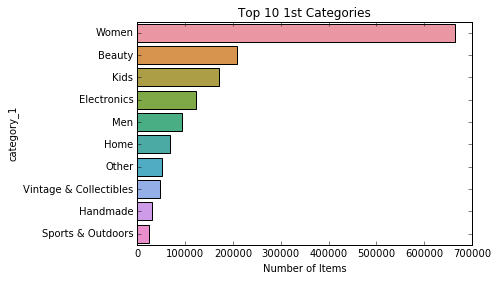

In [11]:
#Top 10 1st Categories 
sns.countplot(y = df.category_1, order = df.category_1.value_counts().iloc[:10].index)
plt.title('Top 10 1st Categories')
plt.xlabel('Number of Items')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


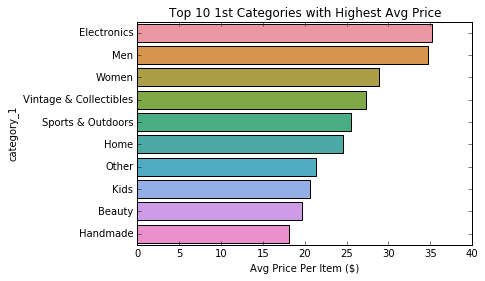

In [12]:
#Top 10 Most Expensive 1st Categories
high_avg_price_1 = pd.DataFrame(df.groupby('category_1')['price'].mean()).sort_values('price',ascending=0).head(10)
sns.barplot(x='price',y=high_avg_price_1.index,data=high_avg_price_1)
plt.title('Top 10 1st Categories with Highest Avg Price')
plt.xlabel('Avg Price Per Item ($)')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


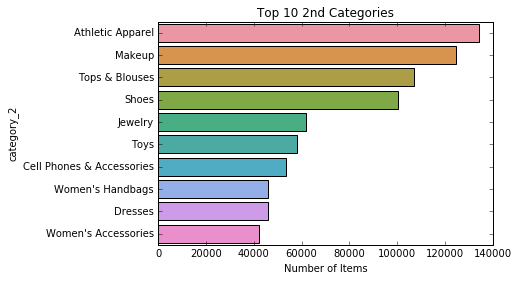

In [13]:
#Top 10 2nd Categories
sns.countplot(y = df.category_2, order = df.category_2.value_counts().iloc[:10].index)
plt.title('Top 10 2nd Categories')
plt.xlabel('Number of Items')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


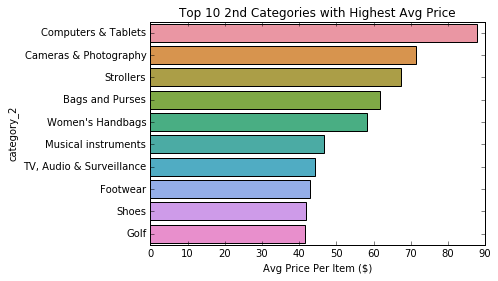

In [14]:
#Top 10 Most Expensive 2nd Categories
high_avg_price_2 = pd.DataFrame(df.groupby('category_2')['price'].mean()).sort_values('price',ascending=0).head(10)
sns.barplot(x='price',y=high_avg_price_2.index,data=high_avg_price_2)
plt.title('Top 10 2nd Categories with Highest Avg Price')
plt.xlabel('Avg Price Per Item ($)')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


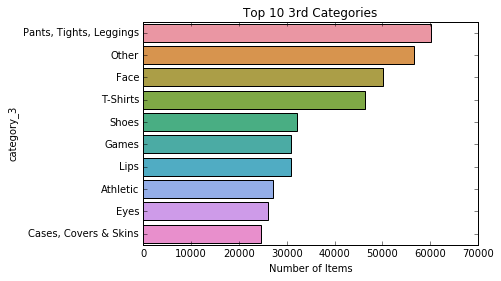

In [15]:
#Top 10 3rd Categories
sns.countplot(y = df.category_3, order = df.category_3.value_counts().iloc[:10].index)
plt.title('Top 10 3rd Categories')
plt.xlabel('Number of Items')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


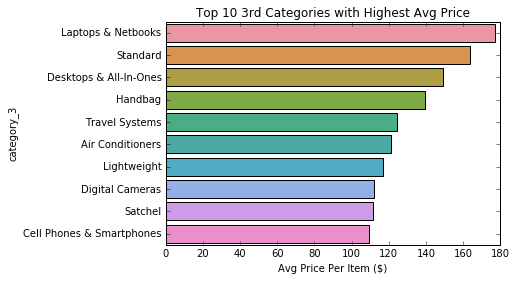

In [16]:
#Top 10 Most Expensive 3rd Categories
high_avg_price_3 = pd.DataFrame(df.groupby('category_3')['price'].mean()).sort_values('price',ascending=0).head(10)
sns.barplot(x='price',y=high_avg_price_3.index,data=high_avg_price_3)
plt.title('Top 10 3rd Categories with Highest Avg Price')
plt.xlabel('Avg Price Per Item ($)')

### Item Conditions

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


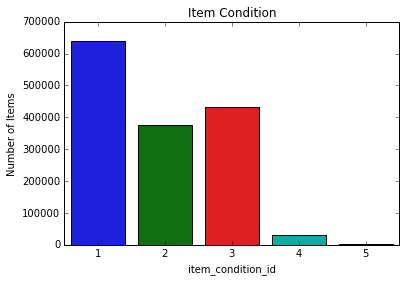

In [17]:
#Item Condition
sns.countplot(df.item_condition_id)
plt.title('Item Condition')
plt.ylabel('Number of Items')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


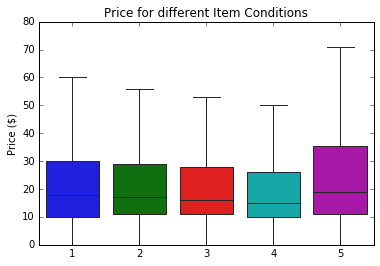

In [155]:
sns.boxplot(x=df.item_condition_id, y = df.price, showfliers=False)
plt.title('Price for different Item Conditions')
plt.ylabel('Price ($)')
plt.xlabel('')

The item conditions are not really explained by Mercari so we don't really know whether 1 represents 'new' quality or 'poor' quality. But, intuitively, the item condition should play a role in determing the item's price. 

### Shipping

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


([<matplotlib.axis.XTick at 0x1a331bb1d0>,
 <a list of 2 Text xticklabel objects>)

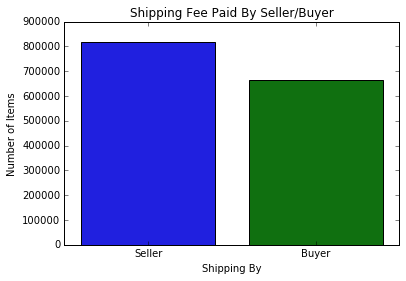

In [18]:
#Is the shipping fee paid by the seller/buyer?
sns.countplot(df.shipping)
plt.title('Shipping Fee Paid By Seller/Buyer')
plt.ylabel('Number of Items')
plt.xlabel('Shipping By')
plt.xticks([0,1],['Seller','Buyer'])

The number of items that the shipping fee are paid by sellers is more than (but not by a lot) the number of items that the shipping fee are paid by buyers. 

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


([<matplotlib.axis.XTick at 0x1a331c6d30>,
 <a list of 2 Text xticklabel objects>)

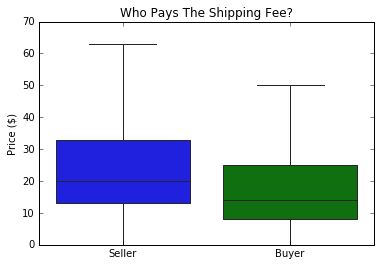

In [19]:
#Are items more expensive when seller pays the shipping fee?
sns.boxplot(x=df.shipping, y = df.price, showfliers=False)
plt.title('Who Pays The Shipping Fee?')
plt.ylabel('Price ($)')
plt.xlabel('')
plt.xticks([0,1],['Seller','Buyer'])

It's as expected that the price of items are higher when sellers pay the shipping fee. 

### Price

In [20]:
df.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

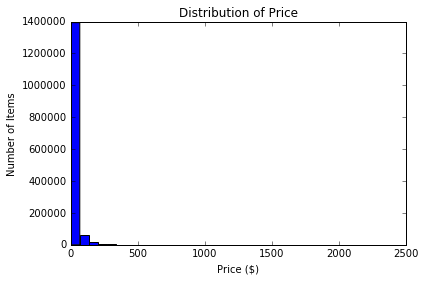

In [21]:
#Price Distribution
plt.hist(df.price,bins=30)
plt.title('Distribution of Price')
plt.ylabel('Number of Items')
plt.xlabel('Price ($)')

The distribution of price is not really clear. There is a whole pile of very cheap items at one end, and the few expensive values aren’t visible at all. Looks like we should log transform the price in order to make the variable better fit the assumptions of underlying regression.

In [22]:
print('99th percentile:', np.percentile(df.price,99))
print('number of $0 item:',(df.price==0).sum())

99th percentile: 170.0
number of $0 item: 874


There are 874 items that have \$0 as the price and the price 99th percentile is \$170. 

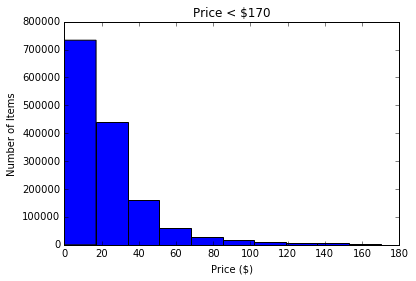

In [23]:
#Price Distribution for items <$170
plt.hist(df[df.price<=170].price)
plt.ylabel('Number of Items')
plt.xlabel('Price ($)')
plt.title('Price < $170')

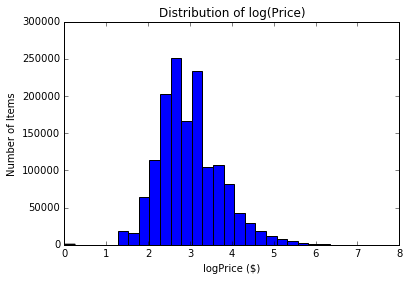

In [24]:
#Log Transform Price
df['logprice'] = np.log1p(df.price)
plt.hist(df.logprice,bins=30)
plt.title('Distribution of log(Price)')
plt.ylabel('Number of Items')
plt.xlabel('logPrice ($)')

After log transforming price, we can see that the distribution of log(price) somehow follows a bell curve. 

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


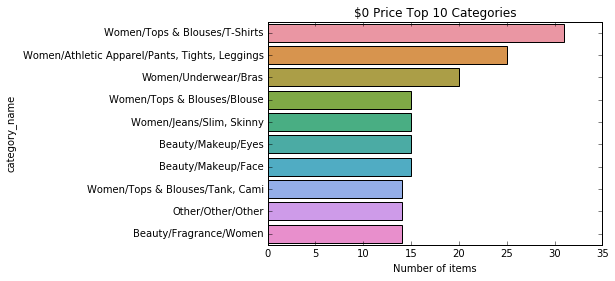

In [25]:
#Which categories have $0 items?
sns.countplot(y = df[df.price==0].category_name, order = df[df.price==0].category_name.value_counts().iloc[:10].index)
plt.title('$0 Price Top 10 Categories')
plt.xlabel('Number of items')

Mostly, Women and Beauty categories have $0 items.

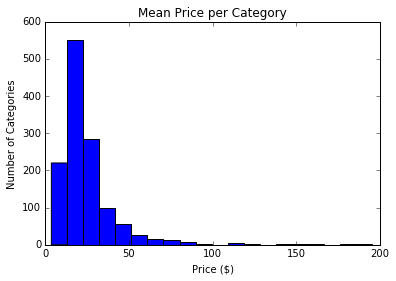

In [26]:
#Distribution of Mean Price per category
mean_price_category = pd.DataFrame(df.groupby('category_name').price.mean())
plt.hist(mean_price_category.price,bins=20)
plt.title('Mean Price per Category')
plt.xlabel('Price ($)')
plt.ylabel('Number of Categories')

Almost all categories have an average item price of <\$100. With most of the categories having an average item price of <\$50.

### Item Description

count    1.482531e+06
mean     1.457118e+02
std      1.744465e+02
min      1.000000e+00
25%      4.000000e+01
50%      8.600000e+01
75%      1.740000e+02
max      1.046000e+03
Name: item_description, dtype: float64


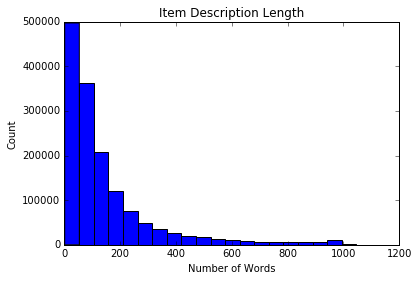

In [27]:
#Number of Words in item description
item_desc_length = df.item_description.str.len()
print(item_desc_length.describe())
_ = plt.hist(item_desc_length.dropna(),bins=20)
plt.title('Item Description Length')
plt.xlabel('Number of Words')
plt.ylabel('Count')

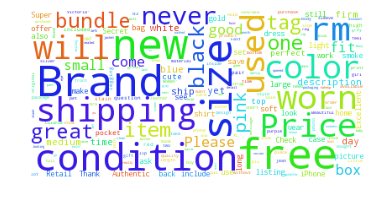

In [28]:
wc = WordCloud(background_color='white', stopwords=STOPWORDS, max_font_size= 50)
wc.generate(' '.join(str(s) for s in df.item_description.values))
plt.axis('off')
plt.imshow(wc)

The word cloud shows what words are most common in the item description. They are standard words used when writing an item description. 

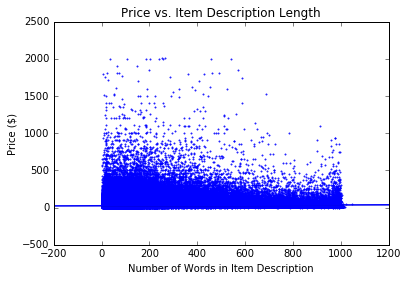

In [115]:
sns.regplot(x=item_desc_length,y='price',data=df,scatter_kws={'s':2})
plt.title('Price vs. Item Description Length')
plt.xlabel('Number of Words in Item Description')
plt.ylabel('Price ($)')

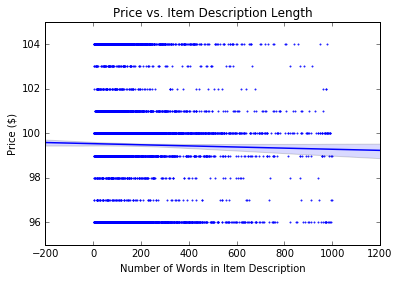

In [120]:
#Let's try to isolate items with $95<price<$105 
#to see more clearly if there is any relationship between price and item description length
sns.regplot(x=df[(df['price']>95) & (df['price']<105)].item_description.str.len(),y='price',data=df[(df['price']>95) & (df['price']<105)],scatter_kws={'s':2})
plt.title('Price vs. Item Description Length')
plt.xlabel('Number of Words in Item Description')
plt.ylabel('Price ($)')

From the scatter plots above, we can see that there is no clear relationship between item description length and price.

### Brands

In [123]:
#number of unique brands
df.brand_name.fillna('Not Specified',inplace=True)
print('There are',len(df.brand_name.unique()),'unique brands.')

There are 4810 unique brands.


//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


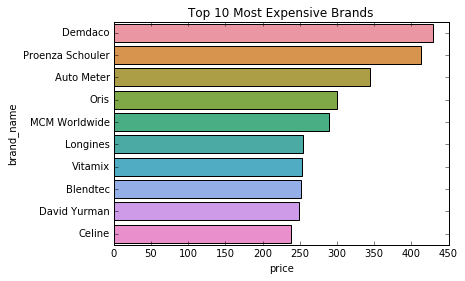

In [33]:
most_expensive_brands = pd.DataFrame(df.groupby('brand_name').price.mean()).sort_values('price',ascending=0).head(10)
sns.barplot(x='price',y=most_expensive_brands.index,data=most_expensive_brands)
plt.title('Top 10 Most Expensive Brands')

The most expensive brands are luxury handbags, watches, and jewelry brands.

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


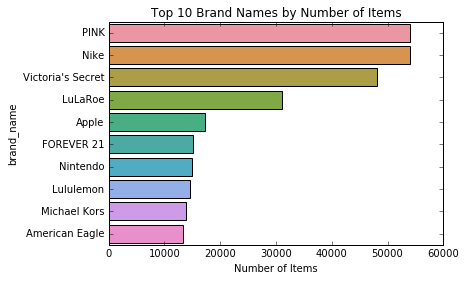

In [34]:
sns.countplot(y = df[df.brand_name!='Not Specified'].brand_name, order = df[df.brand_name!='Not Specified'].brand_name.value_counts().iloc[:10].index)
plt.title('Top 10 Brand Names by Number of Items')
plt.xlabel('Number of Items')

PINK, Nike, and Victoria's Secret are the top 3 brands with most number of items.

### Feature Engineering

In [35]:
df['brand_yesno'] = df['brand_name'].apply(lambda x: not pd.isnull(x))
df['category_yesno'] = df['category_name'].apply(lambda x: not pd.isnull(x))
df['item_description'] = df['item_description'].fillna('No description yet')
df['item_desc_yesno'] = df['item_description'].apply(lambda x: x!='No description yet')
df['item_desc_len'] = df['item_description'].apply(lambda x: len(x))

From wikipedia: term frequency–inverse document frequency (tf-idf), is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. The code below calculates the average TF-IDF score for each item description. The average is calculated by dividing the sum of tfidfs for all words in an item description with the number of words.

In [36]:
def calc_tfidf(desc):
    desc = str(desc)
    desc.translate(string.punctuation)
    tfidfsum=0
    wordscount=0
    for w in desc.lower().split():
        wordscount += 1
        if w in tfidf_dict:
            tfidfsum += tfidf_dict[w]
    if wordscount > 0:
        return tfidfsum/wordscount
    else:
        return 0

tfidf = TfidfVectorizer(
    min_df=5, strip_accents='unicode', lowercase =True,
    analyzer='word', token_pattern=r'\w+', ngram_range=(1, 3), use_idf=True, 
    smooth_idf=True, sublinear_tf=True, stop_words='english')
tfidf.fit_transform(df['item_description'].apply(str)) 
tfidf_dict = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
df['tfidf'] = df['item_description'].apply(calc_tfidf)

In [37]:
df.head(2)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_1,category_2,category_3,category_1_2,logprice,brand_yesno,category_yesno,item_desc_yesno,item_desc_len,tfidf
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Not Specified,10.0,1,No description yet,Men,Tops,T-shirts,Men/Tops,2.397895,True,True,False,18,1.260701
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,Electronics/Computers & Tablets,3.970292,True,True,True,188,2.359801


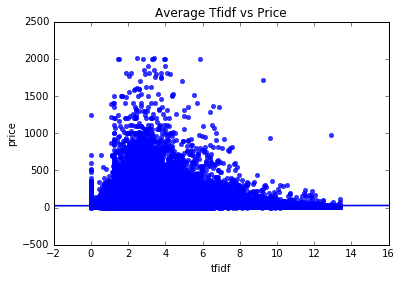

In [38]:
sns.regplot(x='tfidf',y='price',data=df)
plt.title('Average Tfidf vs Price')

The code below creates price features (max,min,mean,median) based on categories, item conditions, and brands.

In [39]:
#Price based on category level
for colname in ['category_name','category_1_2','category_1','category_2','category_3']:
    tmp = pd.DataFrame(df.groupby(colname).agg({'price':{'max_price_'+colname:np.max,
                                                           'min_price_'+colname:np.min,
                                                           'mean_price_'+colname:np.mean,
                                                           'median_price_'+colname:np.median}}))
    tmp.columns = tmp.columns.droplevel(0)
    df = pd.merge(df,tmp,left_on=colname,right_index=True,how='left')

#Price based on category level and item condition
for colname in ['category_name','category_1_2','category_1','category_2','category_3']:
    tmp = pd.DataFrame(df.groupby([colname,'item_condition_id']).agg({'price':{'max_price_cond_'+colname:np.max,
                                                           'min_price_cond_'+colname:np.min,
                                                           'mean_price_cond_'+colname:np.mean,
                                                           'median_price_cond_'+colname:np.median}}))
    tmp.columns = tmp.columns.droplevel(0)
    df = pd.merge(df,tmp,left_on=[colname,'item_condition_id'],right_index=True,how='left')

#Price based on category and brand
tmp = pd.DataFrame(df.groupby(['category_name','brand_name']).agg({'price':{'max_price_brand_category_':np.max,
                                                           'min_price_brand_category_':np.min,
                                                           'mean_price_brand_category_':np.mean,
                                                           'median_price_brand_category_':np.median}}))
tmp.columns = tmp.columns.droplevel(0)
df = pd.merge(df,tmp,left_on=['category_name','brand_name'],right_index=True,how='left')

#Price based on brand
tmp = pd.DataFrame(df.groupby(['brand_name']).agg({'price':{'max_price_brand_':np.max,
                                                           'min_price_brand_':np.min,
                                                           'mean_price_brand_':np.mean,
                                                           'median_price_brand_':np.median}}))
tmp.columns = tmp.columns.droplevel(0)
df = pd.merge(df,tmp,left_on=['brand_name'],right_index=True,how='left')

#Price based on brand and item condition
tmp = pd.DataFrame(df.groupby(['brand_name','item_condition_id']).agg({'price':{'max_price_brand_cond_':np.max,
                                                           'min_price_brand_cond_':np.min,
                                                           'mean_price_brand_cond_':np.mean,
                                                           'median_price_brand_cond_':np.median}}))
tmp.columns = tmp.columns.droplevel(0)
df = pd.merge(df,tmp,left_on=['brand_name','item_condition_id'],right_index=True,how='left')

#Price based on item condition
tmp = pd.DataFrame(df.groupby(['item_condition_id']).agg({'price':{'max_price_cond_':np.max,
                                                           'min_price_cond_':np.min,
                                                           'mean_price_cond_':np.mean,
                                                           'median_price_cond_':np.median}}))
tmp.columns = tmp.columns.droplevel(0)
df = pd.merge(df,tmp,left_on=['item_condition_id'],right_index=True,how='left')

//anaconda/lib/python3.5/site-packages/pandas/core/groupby.py:4189: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


The code below creates score(ranking) of brands by price and by number of items for a specific brand.

In [40]:
ordered_brands_price = pd.DataFrame(df.groupby('brand_name').price.mean()).sort_values('price',ascending=0).index
ordered_brands_count = pd.DataFrame(df.groupby('brand_name').brand_name.count()).sort_values('brand_name',ascending=0).index
df['brand_name_price'] = df['brand_name'].astype('category',ordered=True,categories=ordered_brands_price).cat.codes
df['brand_name_count'] = df['brand_name'].astype('category',ordered=True,categories=ordered_brands_count).cat.codes
df.head()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  app.launch_new_instance()
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_1,category_2,...,min_price_brand_cond_,max_price_brand_cond_,mean_price_brand_cond_,median_price_brand_cond_,median_price_cond_,max_price_cond_,mean_price_cond_,min_price_cond_,brand_name_price,brand_name_count
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Not Specified,10.0,1,No description yet,Men,Tops,...,0.0,1999.0,21.247284,14.0,16.0,2000.0,26.540711,0.0,1904,0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,...,15.0,149.0,46.048780,41.0,16.0,2000.0,26.540711,0.0,580,586
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,...,3.0,197.0,15.998084,12.0,18.0,2009.0,26.486967,0.0,3096,82
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,Not Specified,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,...,0.0,1525.0,20.841802,14.0,18.0,2009.0,26.486967,0.0,1904,0
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,Not Specified,44.0,0,Complete with certificate of authenticity,Women,Jewelry,...,0.0,1525.0,20.841802,14.0,18.0,2009.0,26.486967,0.0,1904,0


### Train Test Split 

In [41]:
train,test = train_test_split(df,test_size=0.2)
print(train.shape)
print(test.shape)

(1186028, 76)
(296507, 76)


### Model 1: Light Gradient Boosting

Light Gradient Boosting (LGBMRegressor) is performed using grid search and cross validation to tune the parameters of the model.

In [44]:
features = [x for x in train.columns if x not in ['train_id','name','category_name','brand_name','price','item_description','category_1','category_2',
       'category_3', 'category_1_2','logprice']]

#Create parameters to search
gridParams = {
    'learning_rate': [0.1,0.2,0.5,0.75],
    'num_leaves': [60,80,100],
    'max_depth':[4,6,8]
    }

#Create classifier to use
lgb_mdl = lgb.LGBMRegressor(boosting_type= 'gbdt', objective = 'regression', metric = 'RMSE')

#Create the grid
grid = GridSearchCV(lgb_mdl, gridParams, verbose=1, cv=3, n_jobs=-1)

#Run the grid
grid.fit(train[features], train['logprice'])

#best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 76.4min finished


{'max_depth': 8, 'learning_rate': 0.5, 'num_leaves': 100}
0.492839671762


Let's refit the model using the best parameters and compute the performance measures.

In [158]:
final_lgb_mdl = lgb.LGBMRegressor(boosting_type= 'gbdt', objective = 'regression', metric = 'RMSE',
                                  learning_rate = grid.best_params_['learning_rate'], 
                                  num_leaves = grid.best_params_['num_leaves'],
                                  max_depth = grid.best_params_['max_depth'])
final_lgb_mdl.fit(train[features], train['logprice'])

lgb_prediction = final_lgb_mdl.predict(test[features])

print('mse on log(Price): ',mean_squared_error(y_true=test['logprice'],y_pred=lgb_prediction))
print('rmse on log(Price): ',np.sqrt(mean_squared_error(y_true=test['logprice'],y_pred=lgb_prediction)))
print('avg price error: ',np.mean(abs(np.expm1(test['logprice'])-np.expm1(lgb_prediction))))

mse on log(Price):  0.283866610945
rmse on log(Price):  0.532791339029
avg price error:  11.604541683899463


//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),
 <a list of 65 Text xticklabel objects>)

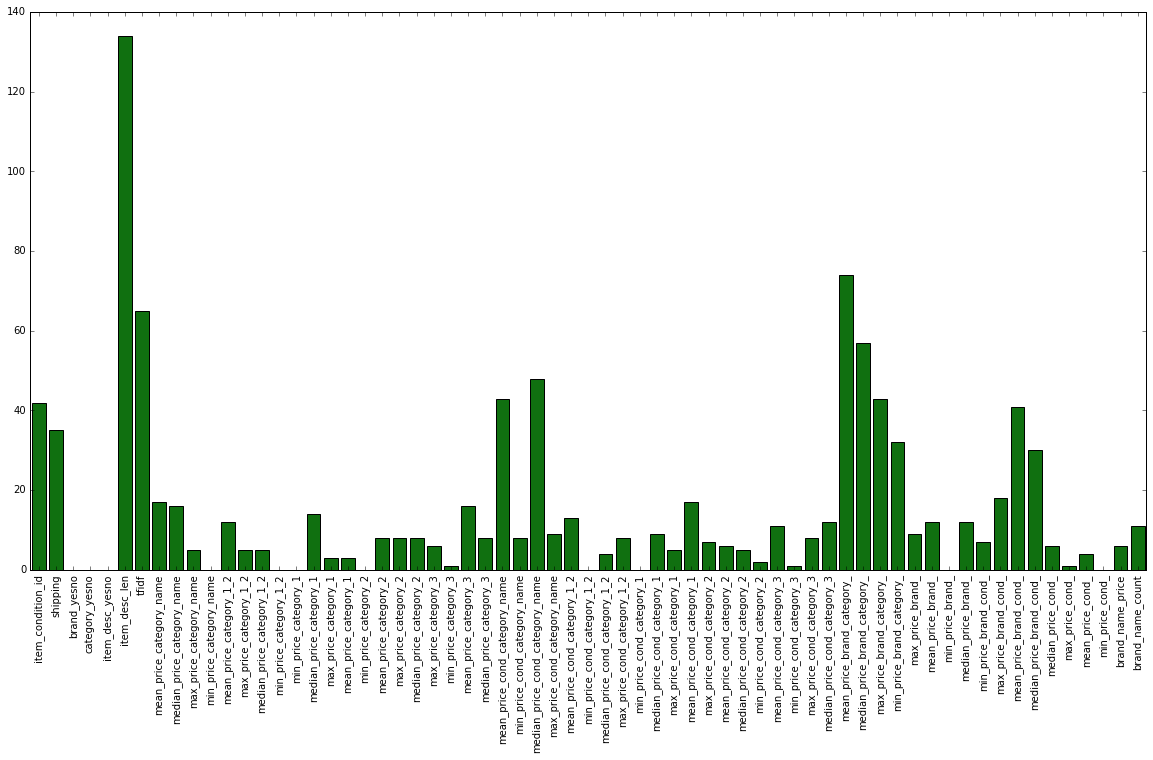

In [71]:
#Plot feature importances
plt.figure(figsize=(20,10))
sns.barplot(features,final_lgb_mdl.feature_importances_,color='green')
plt.xticks(rotation='vertical')

From the feature importances plot above, let's remove some unimportant features (relative importance <= 10)

In [82]:
feature_importances_dict = dict(zip(features,final_lgb_mdl.feature_importances_))

#get only the important features
less_features = [key for key in feature_importances_dict.keys() if feature_importances_dict[key] > 10]
print(len(less_features),len(features))

25 65


We reduce the number of features from 65 to 25. Let's refit the model using only these 25 features.

In [159]:
final_lgb_mdl.fit(train[less_features], train['logprice'])
lgb_prediction = final_lgb_mdl.predict(test[less_features])
print('mse on log(Price): ',mean_squared_error(y_true=test['logprice'],y_pred=lgb_prediction))
print('rmse on log(Price): ',np.sqrt(mean_squared_error(y_true=test['logprice'],y_pred=lgb_prediction)))
print('avg price error: ',np.mean(abs(np.expm1(test['logprice'])-np.expm1(lgb_prediction))))

mse on log(Price):  0.283881667401
rmse on log(Price):  0.532805468629
avg price error:  11.603250468427452


The performance is the same for the 65 features and 25 features.  

### Model 2: Ridge Regression

Ridge Linear Least Squares Regression with CV is performed in this section. The regularization coefficient alpha is also tuned to minimize error.

In [134]:
alphas = [100,10,1,0.1,0.01,0.001,0.0001,0.00001,0]
ridge_mdl = RidgeCV(fit_intercept=True,alphas=alphas,normalize=True,cv=5)
ridge_mdl.fit(train[features], train['logprice'])

RidgeCV(alphas=[100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 0], cv=5,
    fit_intercept=True, gcv_mode=None, normalize=True, scoring=None,
    store_cv_values=False)

In [161]:
print('best alpha:',ridge_mdl.alpha_)
ridge_pred = ridge_mdl.predict(test[features])
print('mse on log(Price): ',mean_squared_error(y_true=test['logprice'],y_pred=ridge_pred))
print('rmse on log(Price): ',np.sqrt(mean_squared_error(y_true=test['logprice'],y_pred=ridge_pred)))
print('avg price error: ',np.mean(abs(np.expm1(test['logprice'])-np.expm1(ridge_pred))))

best alpha: 0.001
mse on log(Price):  0.316908530359
rmse on log(Price):  0.562946294383
avg price error:  13.354043044080294


Light Gradient Boosting performs better than Ridge Regression for predicting price. The comparison is shown below. 

In [162]:
print('--- LGB')
print('mse on log(Price): ',mean_squared_error(y_true=test['logprice'],y_pred=lgb_prediction))
print('rmse on log(Price): ',np.sqrt(mean_squared_error(y_true=test['logprice'],y_pred=lgb_prediction)))
print('avg price error: ',np.mean(abs(np.expm1(test['logprice'])-np.expm1(lgb_prediction))))
print('\n--- Ridge Regression')
print('mse on log(Price): ',mean_squared_error(y_true=test['logprice'],y_pred=ridge_pred))
print('rmse on log(Price): ',np.sqrt(mean_squared_error(y_true=test['logprice'],y_pred=ridge_pred)))
print('avg price error: ',np.mean(abs(np.expm1(test['logprice'])-np.expm1(ridge_pred))))

--- LGB
mse on log(Price):  0.283881667401
rmse on log(Price):  0.532805468629
avg price error:  11.603250468427452

--- Ridge Regression
mse on log(Price):  0.316908530359
rmse on log(Price):  0.562946294383
avg price error:  13.354043044080294
